In [1]:
import os

# Set up Kaggle credentials
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d eryash15/gta-vice-city-car-driving-images-with-label


Dataset URL: https://www.kaggle.com/datasets/eryash15/gta-vice-city-car-driving-images-with-label
License(s): copyright-authors
 97% 468M/484M [00:01<00:00, 270MB/s]
100% 484M/484M [00:01<00:00, 269MB/s]


In [2]:
import zipfile

# Extract the dataset
with zipfile.ZipFile("gta-vice-city-car-driving-images-with-label.zip", 'r') as zip_ref:
    zip_ref.extractall("data")


In [3]:
import os
import pandas as pd

# Define image directory
image_dir = "data/images"  # Adjust this path to your dataset

image_filenames = []
labels = []

for img_name in os.listdir(image_dir):
    if "_" in img_name:  # Ensure the format is correct
        # Split the filename at "_" to separate ID and WASD label
        parts = img_name.split("_")
        if len(parts) == 2:
            label = parts[1].split(".")[0]  # Remove the file extension
            image_filenames.append(img_name)
            labels.append(label)


labels_df = pd.DataFrame({"image_name": image_filenames, "label": labels})

print(labels_df.head())

print(labels_df['label'].value_counts())


     image_name label
0  543_0011.png  0011
1  382_1000.png  1000
2  533_1100.png  1100
3  173_0001.png  0001
4  319_1100.png  1100
label
1000    308
1100     64
1001     47
0000     28
0001     21
0100     17
0010     10
0110      8
0011      7
Name: count, dtype: int64


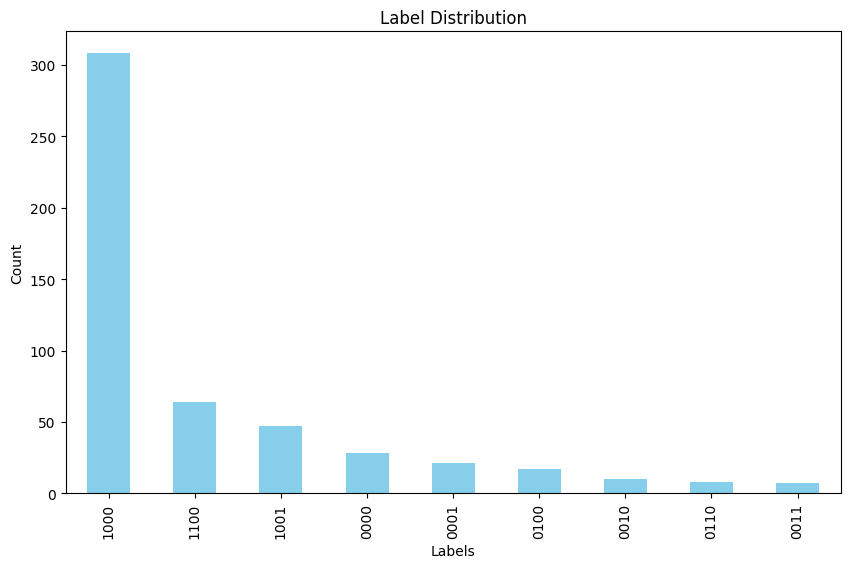

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
labels_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


In [5]:
max_count = labels_df['label'].value_counts().max()
min_count = labels_df['label'].value_counts().min()
imbalance_ratio = max_count / min_count
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("The dataset is imbalanced. Consider using data augmentation or oversampling.")
else:
    print("The dataset has a balanced label distribution.")


Imbalance ratio: 44.00
The dataset is imbalanced. Consider using data augmentation or oversampling.


Images for Label: 0011


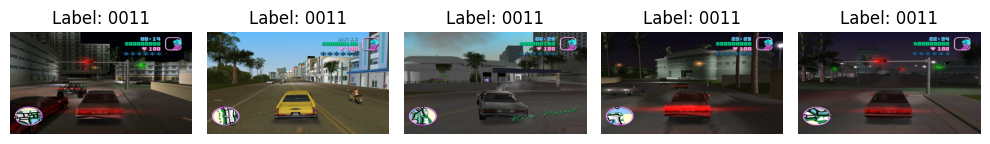

Images for Label: 1000


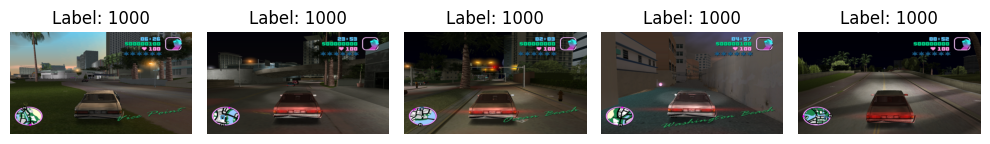

Images for Label: 1100


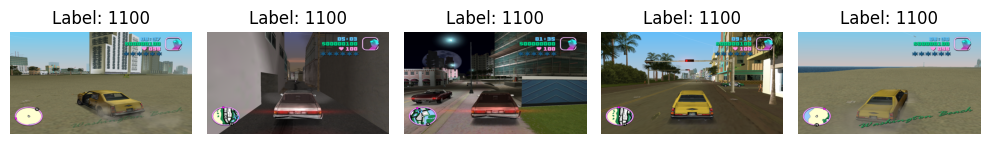

Images for Label: 0001


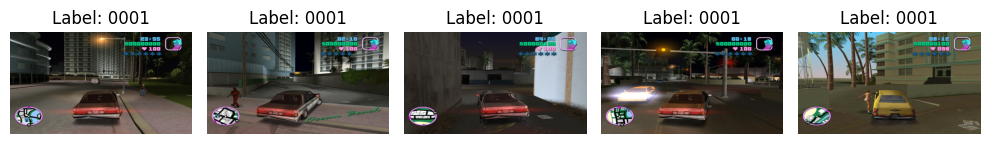

Images for Label: 0000


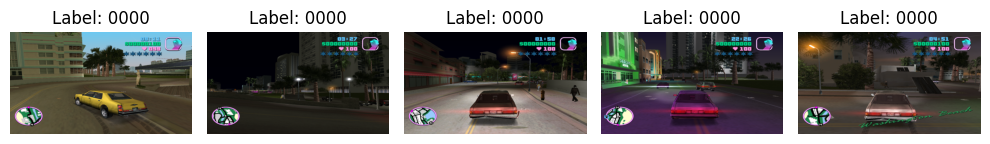

Images for Label: 0010


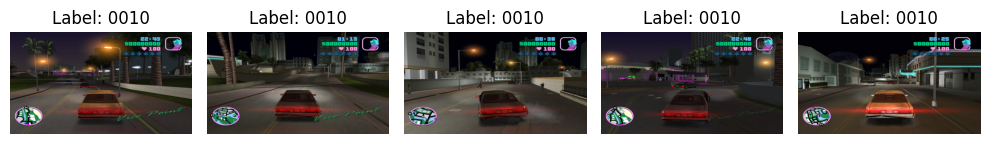

Images for Label: 1001


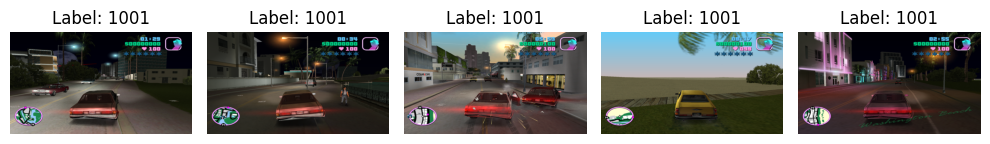

Images for Label: 0100


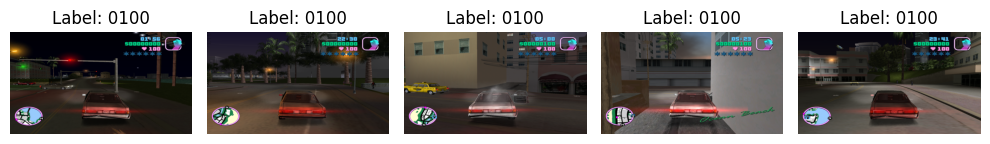

Images for Label: 0110


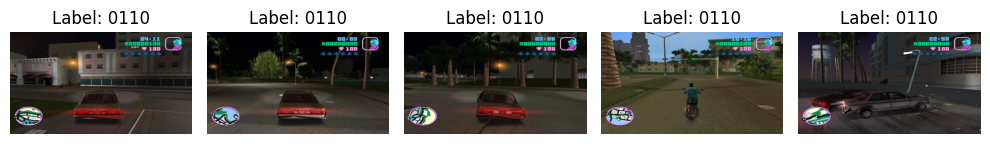

In [6]:
import cv2

def plot_images_for_label(label, num_images=5):
    samples = labels_df[labels_df['label'] == label].sample(min(num_images, len(labels_df[labels_df['label'] == label])))
    plt.figure(figsize=(10, 5))
    for i, row in enumerate(samples.iterrows()):
        img_path = os.path.join(image_dir, row[1]['image_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for label in labels_df['label'].unique():
    print(f"Images for Label: {label}")
    plot_images_for_label(label)


In [7]:
##Resampling the minority Classes

from sklearn.utils import resample

majority_class = labels_df[labels_df['label'] == labels_df['label'].value_counts().idxmax()]
minority_classes = labels_df[labels_df['label'] != labels_df['label'].value_counts().idxmax()]

minority_classes_upsampled = resample(minority_classes,
                                      replace=True,  # Sample with replacement
                                      n_samples=len(majority_class),  # Match majority count
                                      random_state=42)

# Combine majority and upsampled minority classes
balanced_df = pd.concat([majority_class, minority_classes_upsampled])

# Shuffle the data
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
print(balanced_df['label'].value_counts())


label
1000    308
1100     97
1001     75
0000     46
0100     36
0001     23
0010     14
0011      9
0110      8
Name: count, dtype: int64


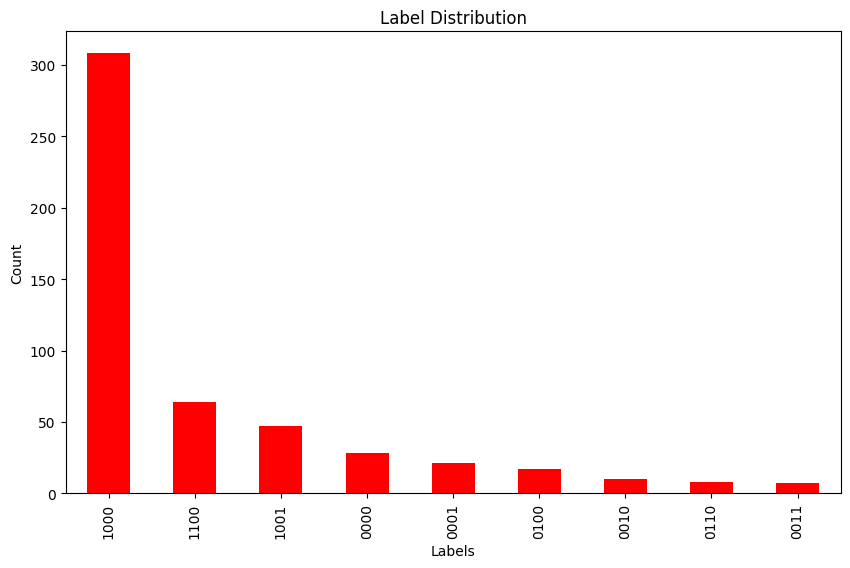

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
labels_df['label'].value_counts().plot(kind='bar', color='r')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 492
Testing data size: 124


In [10]:
from torchvision import transforms

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [11]:
import torch
from PIL import Image

def load_data(df, image_dir):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = f"{image_dir}/{row['image_name']}"
        image = Image.open(img_path).convert('RGB')  # Open image and ensure 3 channels (RGB)
        image = transform(image)  # Apply transformations
        images.append(image)

        label = torch.tensor([int(x) for x in row['label']])  # Convert binary label to tensor
        labels.append(label)

    return torch.stack(images), torch.stack(labels)

# Load training and testing data
train_images, train_labels = load_data(balanced_df, image_dir)  # Use your balanced DataFrame
test_images, test_labels = load_data(test_data, image_dir)

print(f"Training data shape: {train_images.shape}, Labels shape: {train_labels.shape}")
print(f"Testing data shape: {test_images.shape}, Labels shape: {test_labels.shape}")

Training data shape: torch.Size([616, 3, 224, 224]), Labels shape: torch.Size([616, 4])
Testing data shape: torch.Size([124, 3, 224, 224]), Labels shape: torch.Size([124, 4])


In [12]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training data batches: {len(train_loader)}")
print(f"Testing data batches: {len(test_loader)}")


Training data batches: 20
Testing data batches: 4


In [13]:
import torch.nn as nn
from torchvision import models

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier layer to match your number of classes (4)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 114MB/s] 


In [14]:
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


In [16]:
import torch
import torch.nn.functional as F

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and testing loop
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert one-hot encoded labels to class indices
        labels = labels.argmax(dim=1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)

    # Testing phase
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Convert one-hot encoded labels to class indices
            labels = labels.argmax(dim=1)

            outputs = model(images)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}%")

print("Training complete!")


Epoch [1/10] | Loss: 0.6335 | Train Acc: 83.44% | Test Acc: 85.48%
Epoch [2/10] | Loss: 0.4439 | Train Acc: 87.99% | Test Acc: 88.71%
Epoch [3/10] | Loss: 0.2545 | Train Acc: 91.88% | Test Acc: 83.87%
Epoch [4/10] | Loss: 0.1500 | Train Acc: 95.62% | Test Acc: 89.52%
Epoch [5/10] | Loss: 0.1097 | Train Acc: 96.92% | Test Acc: 93.55%
Epoch [6/10] | Loss: 0.1709 | Train Acc: 94.48% | Test Acc: 92.74%
Epoch [7/10] | Loss: 0.1339 | Train Acc: 96.27% | Test Acc: 92.74%
Epoch [8/10] | Loss: 0.1932 | Train Acc: 94.64% | Test Acc: 73.39%
Epoch [9/10] | Loss: 0.0986 | Train Acc: 95.78% | Test Acc: 93.55%
Epoch [10/10] | Loss: 0.0364 | Train Acc: 99.19% | Test Acc: 95.16%
Training complete!


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.argmax(dim=1)  # Convert to class indices
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       105
           1       1.00      0.71      0.83         7
           2       1.00      0.20      0.33         5
           3       0.78      1.00      0.88         7

    accuracy                           0.95       124
   macro avg       0.94      0.73      0.76       124
weighted avg       0.96      0.95      0.94       124



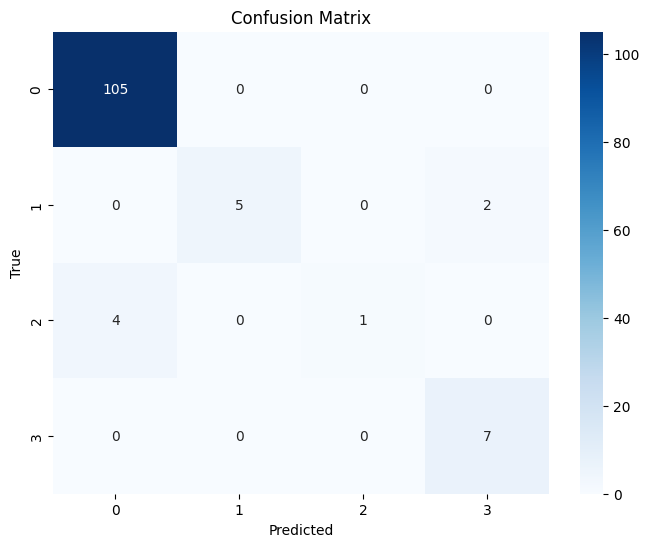

In [19]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [20]:
torch.save(model.state_dict(), "gta_mobilenet_v2.pth")
print("Model saved successfully!")


Model saved successfully!
